# Changes to Particle Flow Network for Deep Sets

## Goals
(In Order)
 - [ ] Experiment with adding TNet to Inputs
 - [ ] Add dropout layers in latent space network
 - [ ] Add Attention Layers
 - [ ] Build Model which handles Tracks Separately

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
from time import perf_counter as cput
import scipy.constants as spc
import matplotlib.ticker as ticker

In [2]:
path_prefix = 'D:/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''
ext_path = "H:/EPE_file_storage/"
ext_modelpath = ext_path + "Model/"
ext_datapath = ext_path + "data_storage/"
ext_plotpath = ext_path + "plots/"

In [3]:
def tvt_num(_data, _tvt=(75, 10, 15)):
    ''' Function designed to output appropriate numbers for traning validation and testing given
    a variable length input. TVT expressed as ratios and do not need to add to 100. '''
    _tot = len(_data)
    _train, _val, _test = _tvt
    _tvt_sum = _train + _val + _test
    
    _train_rtrn = round(_train*_tot/_tvt_sum)
    _val_rtrn = round(_val*_tot/_tvt_sum)
    _test_rtrn = _tot - _train_rtrn - _val_rtrn
    
    return _train_rtrn, _val_rtrn, _test_rtrn

def normalize_input1d(arr, mask):
    ''' Note that non masked values are left alone i.e. zeros if mask = arr != 0'''
    len_arr = arr.shape[0]
    mean = np.repeat(np.mean(arr, where=mask), len_arr)
    std_dev = np.repeat(np.std(arr, where=mask), len_arr)
    norm_arr = np.subtract(arr, mean, out=arr, where=mask)
    std_mask = np.logical_and(std_dev!=0, mask)
    norm_arr = np.divide(norm_arr, std_dev, out=norm_arr, where=std_mask)
    return norm_arr

def normalize_input2d(arr, mask):
    ''' Truth value is where to perform the operation, exclude False vals.
    returns: Array with the shape of arr with normalization carried out with mask '''
    len_ax1 = arr.shape[1]
    mean = np.tile(np.mean(arr, axis=1, where=mask), (len_ax1,1)).transpose()
    std_dev = np.tile(np.std(arr, axis=1, where=mask), (len_ax1,1)).transpose()
    norm_arr = np.subtract(arr, mean, out=arr, where=mask)
    std_mask = np.logical_and(std_dev != 0, mask)
    norm_arr = np.divide(norm_arr, std_dev, out=norm_arr, where=std_mask)
    return norm_arr

In [4]:
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur

In [5]:
stmc = np.load(ext_datapath + "STMC_1.npz")

In [6]:
t0 = t.time()
# load data from NpzFile
Xraw = stmc.f.x
Yraw = stmc.f.y

# load spcific amount of events from raw
X = Xraw[:200000,:,:5]
Y = Yraw[:200000]
print(X.shape)
print(Y.shape)
t1 = t.time()
print('Time to load and copy arrays: '+str(t1-t0)+' (s)')

(41196, 1086, 5)
(41196, 3)
Time to load and copy arrays: 21.285268545150757 (s)


In [7]:
# for PFN approach Y normalization
# the target energy values
# target_zero_mask, Y : 0 for truthPartE, 1 for truthTrackPt, 2 for cluster_eng_clib_tot
target_zero_mask = Y[:,0] > .05
Ylog = np.log(Y[target_zero_mask,0])
print('Any targets below 50 GeV: '+str(np.count_nonzero(np.invert(target_zero_mask))))
print('Number of events: '+str(len(Y)))

Any targets below 50 GeV: 0
Number of events: 41196


In [8]:
# for pfn approach X normalization
# X = [Energy, Eta, Phi, rPerp, Track Flag, Layer]

## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[:,:,2][phi_mask])
X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/cellPhi_std

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model
import keras.backend as Kb

In [10]:
import energyflow as ef
from energyflow.archs import PFN

# Models

In [11]:
import keras as K
import keras.backend as Kb
from tensorflow.keras import activations

def ParticleFlow_base( num_features, name="RussellFlowNetwork"):
    
    mask_val=0.0

    inputs = keras.Input(shape=(None, num_features), name='input')

    dense_0 = layers.Dense(100,name='td_0', activation=activations.relu)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    
    dense_1 = layers.Dense(100,name='td_1', activation=activations.relu)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(t_dist_0)
    
    dense_2 = layers.Dense(128,name='td_2', activation=activations.relu)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(t_dist_1)
    
    lambda_layer = layers.Lambda(lambda X: Kb.cast(Kb.any(Kb.not_equal(X, mask_val), axis=-1), Kb.dtype(X)), output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, t_dist_2])
    
    dense_3 = layers.Dense(100, name='dense_0', activation=activations.relu)(sum_layer)
    
    dense_4 = layers.Dense(100, name='dense_1')(dense_3)
    
    dense_5 = layers.Dense(100, name='dense_2', activation=activations.relu)(dense_4)
    
    dense_6 = layers.Dense(1, name='output', activation=activations.relu)(dense_5)
    
    return keras.Model(inputs=inputs, outputs=dense_6, name=name)

In [11]:
def ParticleFlow_base(num_features, name="RussellFlowNetwork"):
    
    inputs = keras.Input(shape=(None, num_features), name='input')

    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    
    masking_layer = layers.Masking(mask_value=0.0)
    
    lambda_layer = layers.Lambda(lambda X: Kb.cast(Kb.any(Kb.not_equal(X, 0.0), axis=-1), Kb.dtype(X)), output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, activation_2])
    
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(1, name='output')(activation_5)
    activation_6 = layers.Activation('relu', name="activation_6")(dense_6)
    
    return keras.Model(inputs=inputs, outputs=activation_6, name=name)

In [12]:
# EFN regression example uses 75/10/15 split for 100,000 samples
train, val, test = tvt_num(X, _tvt=(75, 10, 15))
print('train -- val -- test')
print(str(train)+' -- '+str(val)+' -- '+str(test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 1500
batch_size = 1000

netOpt = tf.keras.optimizers.Adam(learning_rate=0.001)
RMS_prop = tf.keras.optimizers.RMSprop(learning_rate=0.001)

train -- val -- test
30897 -- 4120 -- 6179


In [13]:
# dataset = tf.data.Dataset.from_tensor_slices((X, Y))
(x_train, x_val, x_test,
 y_train, y_val, y_test) = ef.utils.data_split(X, Ylog, val=val, test=test)

# Print out tensor shapes
print(np.shape(x_train))
print(np.shape(y_train))

(30897, 1086, 5)
(30897,)


In [14]:
# luanch wandb init()
Kb.clear_session()

model = ParticleFlow_base(num_features=5)
model.summary()
model.compile(optimizer = RMS_prop, loss="mse")

Model: "RussellFlowNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
t_dist_0 (TimeDistributed)      (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
t_dist_1 (TimeDistributed)      (None, None, 100)    10100       t_dist_0[0][0]                   
__________________________________________________________________________________________________
mask (Lambda)                   (None, None)         0           input[0][0]                      
_________________________________________________________________________________

In [15]:
chkpoint = tf.keras.callbacks.ModelCheckpoint('pfn_regressor_2g_fs.h5', monitor='loss', verbose=0, save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=300, verbose=0, restore_best_weights=True)
t0 = t.time()
history_ct = model.fit(x_train, y_train,
        epochs=1000,
        batch_size=200,
        validation_data=(x_val, y_val),
        verbose=1,
        callback=[chkpoint, earlystop])
t1 = t.time()

Epoch 1/1000
155/155 [==============================] - 5s 16ms/step - loss: 18.5165 - val_loss: 1.5237
Epoch 2/1000
155/155 [==============================] - 2s 14ms/step - loss: 1.2816 - val_loss: 1.3211
Epoch 3/1000
155/155 [==============================] - 2s 14ms/step - loss: 0.4672 - val_loss: 0.3422
Epoch 4/1000
155/155 [==============================] - 2s 15ms/step - loss: 0.2698 - val_loss: 0.0930
Epoch 5/1000
155/155 [==============================] - 2s 15ms/step - loss: 0.2032 - val_loss: 0.1197
Epoch 6/1000
155/155 [==============================] - 2s 15ms/step - loss: 0.1687 - val_loss: 0.0512
Epoch 7/1000
155/155 [==============================] - 2s 15ms/step - loss: 0.1456 - val_loss: 0.0723
Epoch 8/1000
155/155 [==============================] - 2s 15ms/step - loss: 0.1299 - val_loss: 0.0440
Epoch 9/1000
155/155 [==============================] - 2s 15ms/step - loss: 0.1162 - val_loss: 0.2057
Epoch 10/1000
155/155 [==============================] - 2s 15ms/step - 

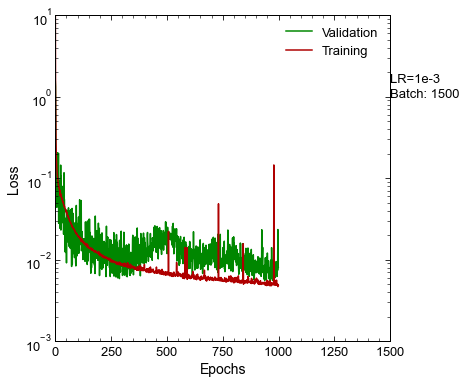

In [16]:
fig = plt.figure(figsize=(6,6))
plt.plot(history_ct.history['val_loss'], label="Validation")
plt.plot(history_ct.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,1500)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(1500, 1.5, 'LR=1e-3', fontsize=13)
plt.text(1500, 1, 'Batch: 1500', fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_lossCurves_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

In [ ]:
model = tf.keras.models.load_model("pfn_regressor_2g_fs.h5")

In [17]:
def eval_generator(data, batch_size):
     batches = (len(data) + batch_size - 1)//batch_size
     for i in range(batches):
          X = data[i*batch_size : (i+1)*batch_size]
          yield (X)

In [18]:
preds = np.exp(model.predict(eval_generator(x_test,500)).flatten())
print(preds.shape)

(6179,)


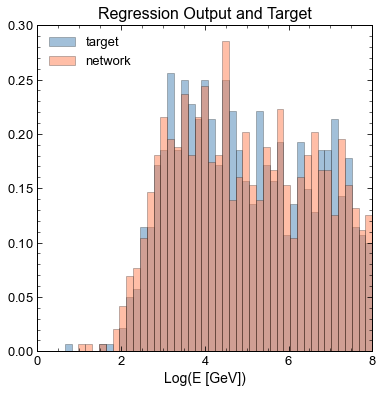

In [19]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.exp(y_test), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_targetPreds_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

<Figure size 799.992x599.976 with 0 Axes>

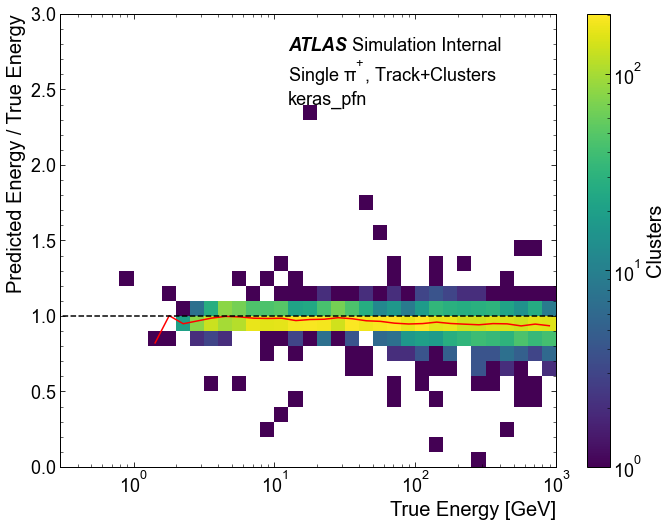

In [27]:
xcenter, medDNN = ru.responsePlot(x=np.exp(y_test), y=preds/np.exp(y_test),
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, Track+Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'keras_pfn'}])

In [21]:
import scipy.stats as stats
# from . import plot_util as pu
from util import plot_util as pu

def _iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return (q84 - q16) / (2 * np.median(x))

def resolutionPlot(x, y, figfile='',
                   xlabel='True Energy [GeV]', ylabel='Response IQR / (2 x Median)',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   xlim=(0.3,1000), ylim=(0,1), 
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqrOverMed).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution

<Figure size 799.992x599.976 with 0 Axes>

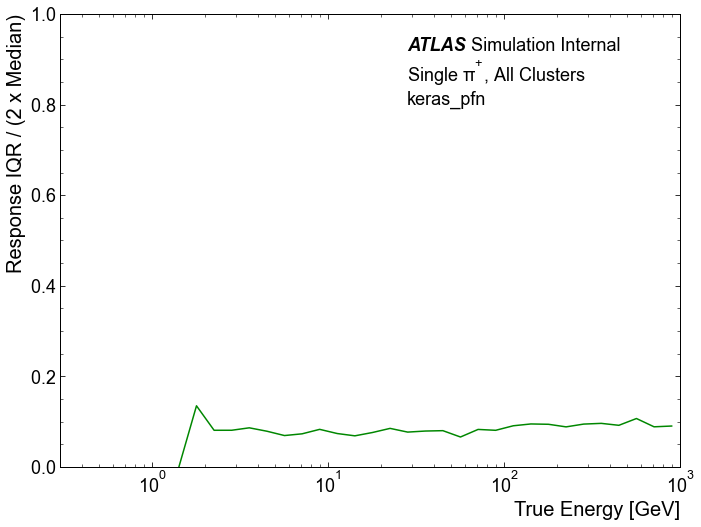

In [28]:
xcenter, iqrMDN3 = resolutionPlot(np.exp(y_test), preds,
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'keras_pfn'}])

<Figure size 799.992x599.976 with 0 Axes>

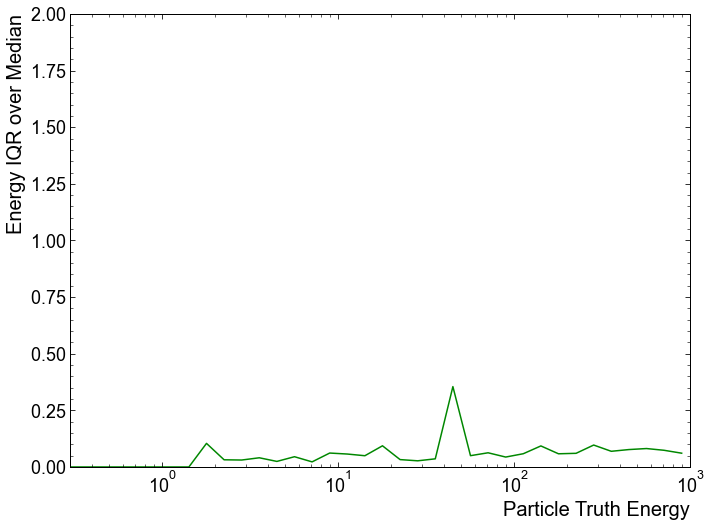

In [23]:
resp_plot = ru.resolutionPlot(x=np.exp(y_test), y=preds/np.exp(y_test),
                    figfile='',
                    statistic='std', xlabel='Particle Truth Energy', ylabel='Energy IQR over Median',
                    atlas_x=-1, atlas_y=-1, simulation=False,
                    textlist=[])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 799.992x599.976 with 0 Axes>

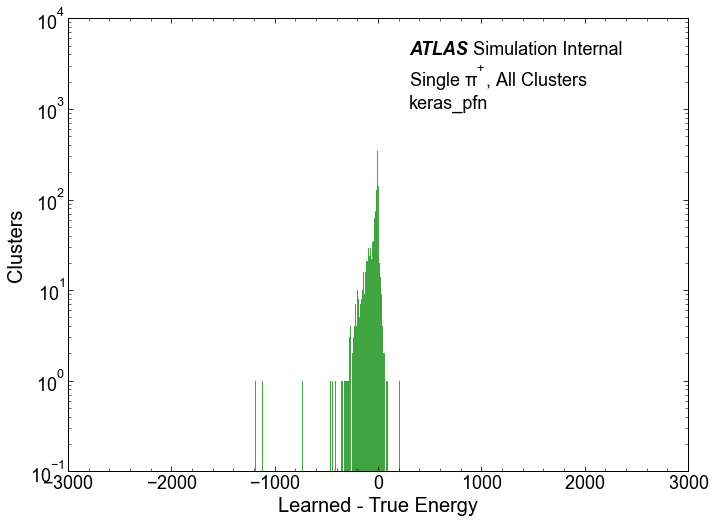

In [29]:
resid_DNN = preds - np.exp(y_test)

n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(resid_DNN,bins = n_bins,alpha=0.75)
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.ylabel('Clusters')
plt.xlim(-3000,3000)
plt.legend()

atlas_x = 0.55
atlas_y = 0.95
simulation = True
textlist = [{'x': 0.55, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.55, 'y': 0.8,  'text': 'keras_pfn'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()